In [6]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load Data ---
with open("new_mb_sweep.json", "r") as f:
    df = pd.DataFrame(json.load(f))
df.sort_values("run_id", inplace=True)

# --- Load Known Potential ---
from potentials import StandardMullerBrown2D
potential = StandardMullerBrown2D()
known_minima = potential.known_minima()
known_saddles = potential.known_saddles()

# --- Utilities ---
def l2_error_to_nearest(point, reference_list):
    return min(np.linalg.norm(np.array(point) - np.array(ref)) for ref in reference_list)

def standard_error(arr):
    arr = np.asarray(arr)
    return np.std(arr, ddof=1) / np.sqrt(len(arr)) if len(arr) > 1 else np.nan

def pad_and_stack_lists(list_of_lists):
    max_len = max(len(lst) for lst in list_of_lists)
    return np.array([list(lst) + [np.nan] * (max_len - len(lst)) for lst in list_of_lists])

def cumulative_to_diffs(lst):
    """Given cumulative list [x, x+y, x+y+z], return increments [x, y, z]."""
    arr = np.array(lst)
    diffs = np.diff(np.insert(arr, 0, 0))
    return diffs

# --- Config ---
N_SEEDS = 10  # adjust as needed
rows = []

# --- Process Blocks ---
for i in range(0, len(df), N_SEEDS):
    block = df.iloc[i:i+N_SEEDS]
    if len(block) < N_SEEDS:
        continue  # skip incomplete block

    all_saddles = []
    all_minima = []
    num_saddles_per_seed = []
    num_minima_per_seed = []

    for j in range(N_SEEDS):
        seed_saddles = block.iloc[j]['found_saddles']
        seed_minima = block.iloc[j]['found_minima']

        unique_saddles = list({tuple(s) for s in seed_saddles})
        unique_minima = list({tuple(m) for m in seed_minima})

        num_saddles_per_seed.append(len(unique_saddles))
        num_minima_per_seed.append(len(unique_minima))

        all_saddles.extend(unique_saddles)
        all_minima.extend(unique_minima)

    all_saddles = list({tuple(s) for s in all_saddles})
    all_minima = list({tuple(m) for m in all_minima})

    saddle_errors = [l2_error_to_nearest(sad, known_saddles) for sad in all_saddles]
    minima_errors = [l2_error_to_nearest(min_, known_minima) for min_ in all_minima]

    bias_counts = block['bias_count'].values

    summary = {
        'run_id': block['run_id'].min(),
        'saddle_error_mean': np.mean(saddle_errors),
        'saddle_error_stderr': standard_error(saddle_errors),
        'minima_error_mean': np.mean(minima_errors),
        'minima_error_stderr': standard_error(minima_errors),
        'bias_count_mean': np.mean(bias_counts),
        'bias_count_stderr': standard_error(bias_counts),
        'num_minima_mean': np.mean(num_minima_per_seed),
        'num_minima_stderr': standard_error(num_minima_per_seed),
        'num_saddles_mean': np.mean(num_saddles_per_seed),
        'num_saddles_stderr': standard_error(num_saddles_per_seed),
    }

    energy_lists = block['energy_calls_at_each_min'].tolist()
    force_lists = block['force_calls_at_each_min'].tolist()

    energy_increments = [cumulative_to_diffs(lst) for lst in energy_lists]
    force_increments = [cumulative_to_diffs(lst) for lst in force_lists]

    energy_array = pad_and_stack_lists(energy_increments)
    force_array = pad_and_stack_lists(force_increments)

    summary.update({
        'energy_calls_mean': np.nanmean(energy_array, axis=0).tolist(),
        'energy_calls_stderr': (np.nanstd(energy_array, axis=0, ddof=1) / np.sqrt(N_SEEDS)).tolist(),
        'force_calls_mean': np.nanmean(force_array, axis=0).tolist(),
        'force_calls_stderr': (np.nanstd(force_array, axis=0, ddof=1) / np.sqrt(N_SEEDS)).tolist(),

        'mean_force_calls_per_min': np.nanmean(force_array).item(),
        'stdv_force_calls_per_min': np.nanstd(force_array, ddof=1).item(),
        'mean_energy_calls_per_min': np.nanmean(energy_array).item(),
        'stdv_energy_calls_per_min': np.nanstd(energy_array, ddof=1).item(),
    })

    config_keys = [
        'bias_std_dev_scale', 'bias_covariance', 'bias_height_fraction',
        'bias_height', 'perturbation_size', 'optimizer'
    ]
    for key in config_keys:
        summary[key] = block.iloc[0][key]

    rows.append(summary)

# --- Aggregate and Filter ---
agg_df = pd.DataFrame(rows)
agg_df = agg_df[
    (agg_df['num_minima_mean'] == 3) &
    (agg_df['num_saddles_mean'] == 2)
].copy()


In [7]:
agg_df

,run_id,saddle_error_mean,saddle_error_stderr,minima_error_mean,minima_error_stderr,bias_count_mean,bias_count_stderr,num_minima_mean,num_minima_stderr,num_saddles_mean,...,mean_force_calls_per_min,stdv_force_calls_per_min,mean_energy_calls_per_min,stdv_energy_calls_per_min,bias_std_dev_scale,bias_covariance,bias_height_fraction,bias_height,perturbation_size,optimizer
0,0,0.805537,0.075369,9.492976e-04,3.892101e-04,17.5,2.709038,3.0,0.0,2.0,...,725.433333,861.874968,725.433333,861.874968,0.333333,0.033611,0.200000,7.600000,0.550,FIRE
1,10,0.849521,0.069805,2.334236e-05,1.166354e-05,11.0,1.751190,3.0,0.0,2.0,...,58.566667,82.209020,58.566667,82.209020,0.333333,0.033611,0.200000,7.600000,0.550,Scipy
4,168,0.836715,0.069608,9.316400e-06,3.686336e-06,22.2,4.918898,3.0,0.0,2.0,...,427.166667,1300.116973,427.166667,1300.116973,0.333333,0.033611,0.033333,1.266667,0.550,FIRE
7,326,0.850813,0.068210,5.143442e-06,1.755698e-06,62.2,14.007776,3.0,0.0,2.0,...,1909.266667,4703.988718,1909.266667,4703.988718,0.333333,0.033611,0.010000,0.380000,0.550,FIRE
9,417,0.404764,0.089019,1.053115e-04,8.610301e-05,53.6,9.872746,3.0,0.0,2.0,...,2020.066667,2925.521762,2020.066667,2925.521762,0.200000,0.012100,0.200000,7.600000,0.550,Scipy
10,427,0.248185,0.035147,1.327631e-04,1.026422e-04,40.8,6.579091,3.0,0.0,2.0,...,901.166667,1880.071717,901.166667,1880.071717,0.200000,0.012100,0.200000,7.600000,0.010,FIRE
11,437,0.187543,0.037931,1.122079e-04,8.576827e-05,54.5,8.426479,3.0,0.0,2.0,...,1971.000000,2934.825425,1971.000000,2934.825425,0.200000,0.012100,0.200000,7.600000,0.010,Scipy
12,447,0.203950,0.028078,1.430457e-04,1.088511e-04,45.8,8.444327,3.0,0.0,2.0,...,1032.033333,2181.895293,1032.033333,2181.895293,0.200000,0.012100,0.200000,7.600000,0.005,FIRE
13,457,0.180741,0.037766,1.061030e-04,8.135991e-05,57.0,6.907323,3.0,0.0,2.0,...,1987.333333,2817.713274,1987.333333,2817.713274,0.200000,0.012100,0.200000,7.600000,0.005,Scipy
14,467,0.204892,0.036307,1.347104e-04,1.016855e-04,54.8,6.271275,3.0,0.0,2.0,...,1094.333333,1991.975026,1094.333333,1991.975026,0.200000,0.012100,0.200000,7.600000,0.001,FIRE


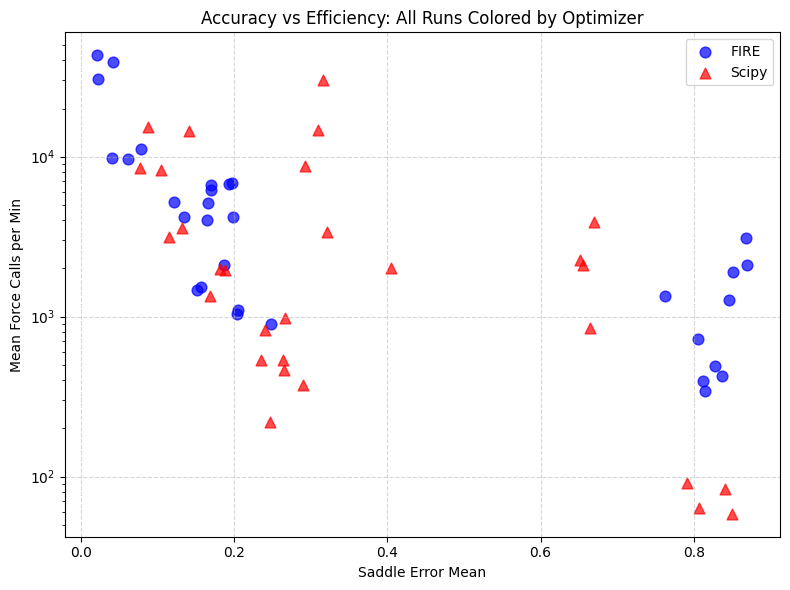

In [11]:
import matplotlib.pyplot as plt

# --- Split data by optimizer ---
fire_runs = agg_df[agg_df['optimizer'] == 'FIRE']
scipy_runs = agg_df[agg_df['optimizer'] == 'Scipy']

# --- Plot ---
plt.figure(figsize=(8, 6))

plt.scatter(
    fire_runs['saddle_error_mean'],
    fire_runs['mean_force_calls_per_min'],
    color='blue', label='FIRE', alpha=0.7, s=60, marker='o'
)
plt.scatter(
    scipy_runs['saddle_error_mean'],
    scipy_runs['mean_force_calls_per_min'],
    color='red', label='Scipy', alpha=0.7, s=60, marker='^'
)

# --- Labels, scale, and legend ---
plt.xlabel('Saddle Error Mean')
plt.ylabel('Mean Force Calls per Min')
plt.title('Accuracy vs Efficiency: All Runs Colored by Optimizer')
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
agg_df

,run_id,saddle_error_mean,saddle_error_stderr,minima_error_mean,minima_error_stderr,bias_count_mean,bias_count_stderr,num_minima_mean,num_minima_stderr,num_saddles_mean,...,mean_force_calls_per_min,stdv_force_calls_per_min,mean_energy_calls_per_min,stdv_energy_calls_per_min,bias_std_dev_scale,bias_covariance,bias_height_fraction,bias_height,perturbation_size,optimizer
0,0,0.805537,0.075369,9.492976e-04,3.892101e-04,17.5,2.709038,3.0,0.0,2.0,...,725.433333,861.874968,725.433333,861.874968,0.333333,0.033611,0.200000,7.600000,0.550,FIRE
1,10,0.849521,0.069805,2.334236e-05,1.166354e-05,11.0,1.751190,3.0,0.0,2.0,...,58.566667,82.209020,58.566667,82.209020,0.333333,0.033611,0.200000,7.600000,0.550,Scipy
4,168,0.836715,0.069608,9.316400e-06,3.686336e-06,22.2,4.918898,3.0,0.0,2.0,...,427.166667,1300.116973,427.166667,1300.116973,0.333333,0.033611,0.033333,1.266667,0.550,FIRE
7,326,0.850813,0.068210,5.143442e-06,1.755698e-06,62.2,14.007776,3.0,0.0,2.0,...,1909.266667,4703.988718,1909.266667,4703.988718,0.333333,0.033611,0.010000,0.380000,0.550,FIRE
9,417,0.404764,0.089019,1.053115e-04,8.610301e-05,53.6,9.872746,3.0,0.0,2.0,...,2020.066667,2925.521762,2020.066667,2925.521762,0.200000,0.012100,0.200000,7.600000,0.550,Scipy
10,427,0.248185,0.035147,1.327631e-04,1.026422e-04,40.8,6.579091,3.0,0.0,2.0,...,901.166667,1880.071717,901.166667,1880.071717,0.200000,0.012100,0.200000,7.600000,0.010,FIRE
11,437,0.187543,0.037931,1.122079e-04,8.576827e-05,54.5,8.426479,3.0,0.0,2.0,...,1971.000000,2934.825425,1971.000000,2934.825425,0.200000,0.012100,0.200000,7.600000,0.010,Scipy
12,447,0.203950,0.028078,1.430457e-04,1.088511e-04,45.8,8.444327,3.0,0.0,2.0,...,1032.033333,2181.895293,1032.033333,2181.895293,0.200000,0.012100,0.200000,7.600000,0.005,FIRE
13,457,0.180741,0.037766,1.061030e-04,8.135991e-05,57.0,6.907323,3.0,0.0,2.0,...,1987.333333,2817.713274,1987.333333,2817.713274,0.200000,0.012100,0.200000,7.600000,0.005,Scipy
14,467,0.204892,0.036307,1.347104e-04,1.016855e-04,54.8,6.271275,3.0,0.0,2.0,...,1094.333333,1991.975026,1094.333333,1991.975026,0.200000,0.012100,0.200000,7.600000,0.001,FIRE


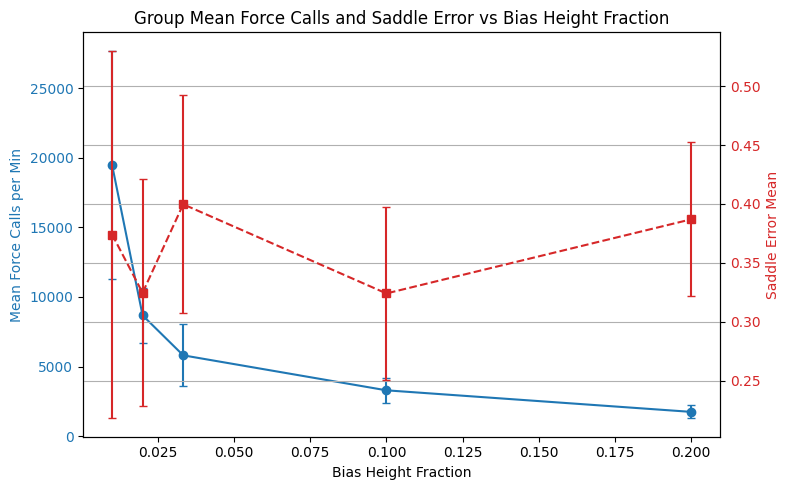

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Sanity check
assert (agg_df['mean_force_calls_per_min'] >= 0).all(), "Negative values in agg_df!"

# Filter valid entries
contender_params = agg_df[
    (agg_df['num_minima_mean'] == 3) &
    (agg_df['num_saddles_mean'] == 2)
].copy()

# Drop rows with missing values in key columns
contender_params = contender_params.dropna(subset=[
    'bias_height_fraction',
    'mean_force_calls_per_min', 'stdv_force_calls_per_min',
    'saddle_error_mean', 'saddle_error_stderr'
])

# Group and compute unweighted group statistics
grouped_df = (
    contender_params
    .groupby('bias_height_fraction')
    .agg({
        'mean_force_calls_per_min': ['mean', 'sem'],
        'saddle_error_mean': ['mean', 'sem']
    })
    .reset_index()
)

# Flatten column names
grouped_df.columns = [
    'bias_height_fraction',
    'mean_force_calls_per_min', 'std_force_calls_per_min',
    'mean_saddle_error', 'std_saddle_error'
]

# Assert no negatives again (we're being paranoid now)
assert (grouped_df['mean_force_calls_per_min'] >= 0).all(), "Negative values still present!"

# Plot
x = grouped_df['bias_height_fraction']
y1 = grouped_df['mean_force_calls_per_min']
y1_err = grouped_df['std_force_calls_per_min']

y2 = grouped_df['mean_saddle_error']
y2_err = grouped_df['std_saddle_error']

fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.set_xlabel('Bias Height Fraction')
ax1.set_ylabel('Mean Force Calls per Min', color=color1)
ax1.errorbar(x, y1, yerr=y1_err, fmt='o-', color=color1, capsize=3)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Saddle Error Mean', color=color2)
ax2.errorbar(x, y2, yerr=y2_err, fmt='s--', color=color2, capsize=3)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Group Mean Force Calls and Saddle Error vs Bias Height Fraction')
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
agg_df

,run_id,saddle_error_mean,saddle_error_stderr,minima_error_mean,minima_error_stderr,bias_count_mean,bias_count_stderr,num_minima_mean,num_minima_stderr,num_saddles_mean,...,mean_force_calls_per_min,stdv_force_calls_per_min,mean_energy_calls_per_min,stdv_energy_calls_per_min,bias_std_dev_scale,bias_covariance,bias_height_fraction,bias_height,perturbation_size,optimizer
0,0,0.805537,0.075369,9.492976e-04,3.892101e-04,17.5,2.709038,3.0,0.0,2.0,...,725.433333,861.874968,725.433333,861.874968,0.333333,0.033611,0.200000,7.600000,0.550,FIRE
1,10,0.849521,0.069805,2.334236e-05,1.166354e-05,11.0,1.751190,3.0,0.0,2.0,...,58.566667,82.209020,58.566667,82.209020,0.333333,0.033611,0.200000,7.600000,0.550,Scipy
4,168,0.836715,0.069608,9.316400e-06,3.686336e-06,22.2,4.918898,3.0,0.0,2.0,...,427.166667,1300.116973,427.166667,1300.116973,0.333333,0.033611,0.033333,1.266667,0.550,FIRE
7,326,0.850813,0.068210,5.143442e-06,1.755698e-06,62.2,14.007776,3.0,0.0,2.0,...,1909.266667,4703.988718,1909.266667,4703.988718,0.333333,0.033611,0.010000,0.380000,0.550,FIRE
9,417,0.404764,0.089019,1.053115e-04,8.610301e-05,53.6,9.872746,3.0,0.0,2.0,...,2020.066667,2925.521762,2020.066667,2925.521762,0.200000,0.012100,0.200000,7.600000,0.550,Scipy
10,427,0.248185,0.035147,1.327631e-04,1.026422e-04,40.8,6.579091,3.0,0.0,2.0,...,901.166667,1880.071717,901.166667,1880.071717,0.200000,0.012100,0.200000,7.600000,0.010,FIRE
11,437,0.187543,0.037931,1.122079e-04,8.576827e-05,54.5,8.426479,3.0,0.0,2.0,...,1971.000000,2934.825425,1971.000000,2934.825425,0.200000,0.012100,0.200000,7.600000,0.010,Scipy
12,447,0.203950,0.028078,1.430457e-04,1.088511e-04,45.8,8.444327,3.0,0.0,2.0,...,1032.033333,2181.895293,1032.033333,2181.895293,0.200000,0.012100,0.200000,7.600000,0.005,FIRE
13,457,0.180741,0.037766,1.061030e-04,8.135991e-05,57.0,6.907323,3.0,0.0,2.0,...,1987.333333,2817.713274,1987.333333,2817.713274,0.200000,0.012100,0.200000,7.600000,0.005,Scipy
14,467,0.204892,0.036307,1.347104e-04,1.016855e-04,54.8,6.271275,3.0,0.0,2.0,...,1094.333333,1991.975026,1094.333333,1991.975026,0.200000,0.012100,0.200000,7.600000,0.001,FIRE


Number of runs matching conditions: 2


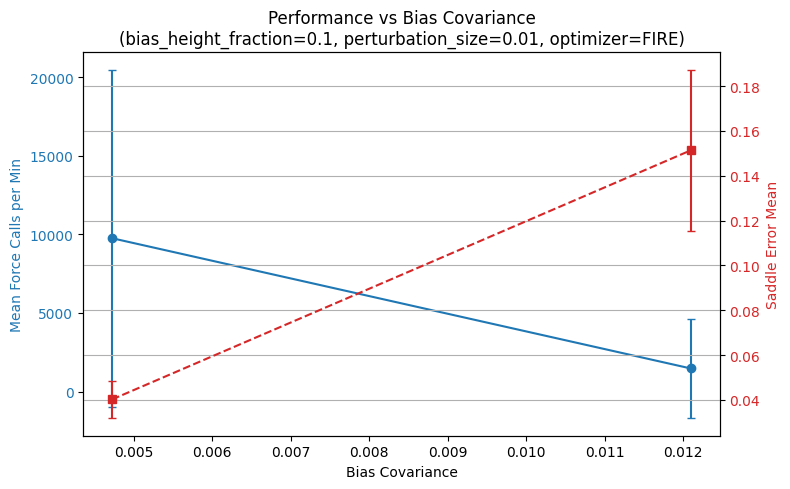

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Filter for given conditions and FIRE optimizer
bias_height_val = 0.1
perturbation_val = 0.01

subset = agg_df[
    (agg_df['bias_height_fraction'] == bias_height_val) &
    (agg_df['perturbation_size'] == perturbation_val) &
    (agg_df['optimizer'] == 'FIRE')
].copy()

print(f"Number of runs matching conditions: {len(subset)}")

# Weighted avg + SEM helper
def weighted_avg_and_sem(values, sems):
    values = np.asarray(values, dtype=float)
    sems = np.asarray(sems, dtype=float)
    sems[sems <= 0] = 1e-12
    valid = ~np.isnan(values) & ~np.isnan(sems)
    if valid.sum() == 0:
        return np.nan, np.nan
    weights = 1 / sems[valid]**2
    weighted_avg = np.sum(weights * values[valid]) / np.sum(weights)
    combined_sem = np.sqrt(1 / np.sum(weights))
    return weighted_avg, combined_sem

# Group by bias_covariance
grouped = []
for cov, group in subset.groupby('bias_covariance'):
    f_avg, f_sem = weighted_avg_and_sem(group['mean_force_calls_per_min'], group['stdv_force_calls_per_min'])
    s_avg, s_sem = weighted_avg_and_sem(group['saddle_error_mean'], group['saddle_error_stderr'])
    
    grouped.append({
        'bias_covariance': cov,
        'mean_force_calls_per_min': f_avg,
        'std_force_calls_per_min': f_sem,
        'mean_saddle_error': s_avg,
        'std_saddle_error': s_sem
    })

grouped_df = pd.DataFrame(grouped).sort_values('bias_covariance')

# Plot
x = grouped_df['bias_covariance']
y1 = grouped_df['mean_force_calls_per_min']
y1_err = grouped_df['std_force_calls_per_min']
y2 = grouped_df['mean_saddle_error']
y2_err = grouped_df['std_saddle_error']

fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.set_xlabel('Bias Covariance')
ax1.set_ylabel('Mean Force Calls per Min', color=color1)
ax1.errorbar(x, y1, yerr=y1_err, fmt='o-', color=color1, capsize=3)
ax1.tick_params(axis='y', labelcolor=color1)
# ax1.set_yscale('log')

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Saddle Error Mean', color=color2)
ax2.errorbar(x, y2, yerr=y2_err, fmt='s--', color=color2, capsize=3)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title(f"Performance vs Bias Covariance\n(bias_height_fraction={bias_height_val}, perturbation_size={perturbation_val}, optimizer=FIRE)")
plt.grid(True)
plt.tight_layout()
plt.show()
